# Xe-100-like reactor impurities analysis
This notebook performs analysis the reactor physics and 
performance of an Xe-100-like reactor, the Sangamon200,
using different compositions of HALEU. The compositions are:
* Pure (U-235 and U-238 are the only uranium isotopes)
* EBR-II (HALEU produced from downblended EBR-II spent fuel)
* Y-12 (HALEU prodced from downblended HEU at Y-12)

The reactor physics/performance metrics considered include:
* k-eff
* neutron flux
* beta-eff
* temperature feedback coefficients. 

Each of these metrics are determined for a single burnup step, the initial state. The 
reactor is assumed to be in an isothermal state at 800K, except for the material 
temperatures varied to determine the temperature feedback coefficients. When 
calculating the temperature feedback coefficients, the fuel, coolant, moderator, 
and total fedback coefficients are calculated by varying the respective
material temperatures between 750 (low), 800 (base), and 850 (high) K.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import serpentTools

In [78]:
def calculate_feedback(k_0, k_1, delta_T):
    '''
    Calcualtes feedback coefficient caused by changes in 
    material temepratures
    
    Parameters:
    -----------
    k_0: float
        k-eff at base temperature
    k_1: float
        k-eff at varied temperature
    delta_T: int
        chagne in material temperature
    
    Returns:
    --------
    alpha_t: float
        reactivity feedback coefficient
    '''
    alpha_t = (1/delta_T)*((k_1-k_0)/(k_1*k_0))
    return alpha_t

def error_propagation(k_0, k_1, error_0, error_1, delta_T):
    '''
    Performs error propagation for the calculation 
    of the temperature feedback coefficients
    
    Parameters:
    -----------
    k_0: int, float
        k-eff at base temperature
    k_1: int, float
        k-eff at varied temperature
    error_0: int, float
        error for k_0 value
    error_1: int, float
        error for k_1
    delta_T: int, float
        change in temperature
    
    Returns
    -------
    prop_error: int, float
        propagated error
    '''
    prop_error = np.sqrt(
                         error_1**2*((1/delta_T)*(1/k_1**2))**2 +
                         error_0**2*(-(1/delta_T)*(1/k_0**2))**2
                        )
    return prop_error

In [51]:
out_files = {'results': {'pure':'xe100_pure_res.m'},
             'detectors':{'pure':'xe100_pure_det0.m'}}

## k-eff

In [72]:
k_eff = {'pure':{}, 'ebr2':{}, 'y12':{}}; k_eff_error = {'pure':{},'ebr2':{}, 'y12':{}}
for key in k_eff:
    k_eff[key] = {'bbb':0, 'lbb':0, 'blb':0, 'bbl':0, 'lll':0, 
                 'hbb':0, 'bhb':0, 'bbh':0, 'hhh':0}
    k_eff_error[key] = {'bbb':0, 'lbb':0, 'blb':0, 'bbl':0, 'lll':0, 
                 'hbb':0, 'bhb':0, 'bbh':0, 'hhh':0}
    
for fuel in out_files['results']:
    file = serpentTools.read(out_files['results'][fuel])
    for index, key in enumerate(k_eff[fuel]):
        k_eff[fuel][key] = file.resdata['absKeff'][index][0]
        k_eff_error[fuel][key] = file.resdata['absKeff'][index][1]

SERPENT Serpent 2.1.32 found in xe100_pure_res.m, but version 2.1.31 is defined in settings
  Attemping to read anyway. Please report strange behaviors/failures to developers.


In [73]:
for fuel in k_eff:
    print(f"k_eff for {fuel.capitalize()} fuel: {k_eff[fuel]['bbb']} +/- {k_eff_error[fuel]['bbb']}")

k_eff for Pure fuel: 1.0662 +/- 0.00023
k_eff for Ebr2 fuel: 0 +/- 0
k_eff for Y12 fuel: 0 +/- 0


## Neutron flux

Could not find arguments in index that match the following requested slice keys: xmesh
Could not find arguments in index that match the following requested slice keys: xmesh


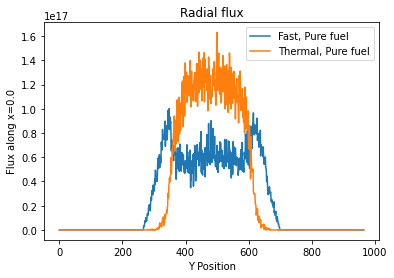

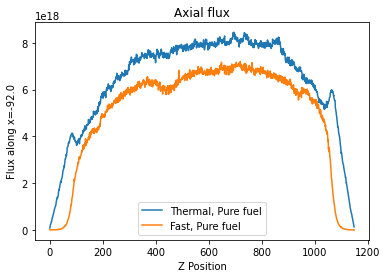

In [40]:
for index, fuel in enumerate(out_files['detectors']):

    detectors = serpentTools.read(out_files['detectors'][fuel], 'det')
    radial = detectors.detectors['radial_flux']
    axial = detectors.detectors['axial_flux']
      
    plt.figure(counter)
    radial.plot(fixed={'energy':0, 'xmesh':483}, label=f'Fast, {fuel.capitalize()} fuel')
    radial.plot(fixed={'energy':1, 'xmesh':483}, xlabel='Y Position',
                ylabel = 'Flux along x={}'.format(radial.grids['X'][483,0]),
                label=f'Thermal, {fuel.capitalize()} fuel')
    plt.title(f"Radial flux")
     
    plt.figure(counter+1)
    axial.plot(fixed={'energy':0, 'xmesh':483}, label=f'Thermal, {fuel.capitalize()} fuel')
    axial.plot(fixed={'energy':1, 'xmesh':483}, label=f'Fast, {fuel.capitalize()} fuel', xlabel= 'Z Position',
              ylabel = 'Flux along x={}'.format(axial.grids['Z'][483,0]))
    plt.title(f"Axial flux")

## beta-eff

In [62]:
beta_eff = {'pure':{}, 'ebr2':{}, 'y12':{}}; beta_eff_error = {'pure':{},'ebr2':{}, 'y12':{}}

for fuel in out_files['results']:
    data = serpentTools.read(out_files['results'][fuel])
    universe = pure_data.getUniv('0', index=0)
    beta_eff[fuel] = universe.gc['betaEff'][0]
    beta_eff_error[fuel] = universe.gcUnc['betaEff'][0]

SERPENT Serpent 2.1.32 found in xe100_pure_res.m, but version 2.1.31 is defined in settings
  Attemping to read anyway. Please report strange behaviors/failures to developers.


In [67]:
for fuel in beta_eff:
    print(f"beta_eff for {fuel.capitalize()} fuel: {beta_eff[fuel]} +/- {beta_eff_error[fuel]}")

beta_eff for Pure fuel: 0.0061459 +/- 0.00768
beta_eff for Ebr2 fuel: {} +/- {}
beta_eff for Y12 fuel: {} +/- {}


## temperatrue feedback coefficients

In [81]:
temp_coeffs = {'pure':{},'ebr':{}, 'y12':{}}
temp_coeffs_error = {'pure':{},'ebr':{}, 'y12':{}}
for key in temp_coeffs:
    temp_coeffs[key] = {'hbb':0, 'bhb':0, 'bbh':0, 'hhh':0, 'lbb':0,'blb':0, 'bbl':0, 'lll':0}
    temp_coeffs_error[key] = {'hbb':0, 'bhb':0, 'bbh':0, 'hhh':0, 'lbb':0,'blb':0, 'bbl':0, 'lll':0}
for fuel in ['pure']:
    for key in k_eff['pure']:
        temp_coeffs[fuel][key] = calculate_feedback(k_eff[fuel]['bbb'], k_eff[fuel][key], 50)
        temp_coeffs_error[fuel][key] = error_propagation(k_eff[fuel]['bbb'], 
                                                          k_eff[fuel][key], 
                                                          k_eff_error[fuel]['bbb'],
                                                          k_eff_error[fuel][key], 
                                                          50)

Text(0, 0.5, 'k-eff')

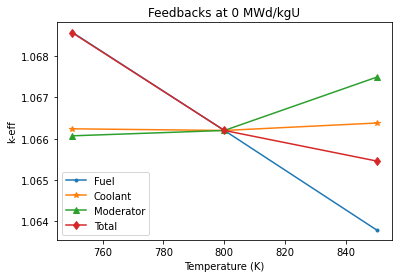

In [43]:
temps = [750, 800, 850]
plt.figure()
plt.plot(temps, [k_eff['pure']['lbb'][0], k_eff['pure']['bbb'][0], k_eff['pure']['hbb'][0]], marker='.', label='Fuel')
plt.plot(temps, [k_eff['pure']['blb'][0], k_eff['pure']['bbb'][0], k_eff['pure']['bhb'][0]], marker='*', label='Coolant')
plt.plot(temps, [k_eff['pure']['bbl'][0], k_eff['pure']['bbb'][0], k_eff['pure']['bbh'][0]], marker='^', label='Moderator')
plt.plot(temps, [k_eff['pure']['lll'][0], k_eff['pure']['bbb'][0], k_eff['pure']['hhh'][0]], marker='d', label='Total')
plt.legend()
plt.title("Feedbacks at 0 MWd/kgU")
plt.xlabel('Temperature (K)')
plt.ylabel('k-eff')

In [82]:
for fuel in temp_coeffs:
    for key in temp_coeffs[fuel]:
        print(fuel, key, f"{temp_coeffs[fuel][key]*1e5} +/- {temp_coeffs_error[fuel][key]*1e5}")

pure hbb -4.249643085966782 +/- 0.5490783607168984
pure bhb 0.31662983259064637 +/- 0.5598701560456645
pure bbh 2.2668209222489457 +/- 0.5593146391158095
pure hhh -1.3028244109983882 +/- 0.5251609861166152
pure lbb 4.177930710170821 +/- 0.5468398247939484
pure blb 0.07037142375246384 +/- 0.559940387461968
pure bbl -0.22874359779435263 +/- 0.5249169644498887
pure lll 4.160415313511305 +/- 0.5352198324935017
pure bbb 0.0 +/- 0.5722627442165835
ebr hbb 0.0 +/- 0.0
ebr bhb 0.0 +/- 0.0
ebr bbh 0.0 +/- 0.0
ebr hhh 0.0 +/- 0.0
ebr lbb 0.0 +/- 0.0
ebr blb 0.0 +/- 0.0
ebr bbl 0.0 +/- 0.0
ebr lll 0.0 +/- 0.0
y12 hbb 0.0 +/- 0.0
y12 bhb 0.0 +/- 0.0
y12 bbh 0.0 +/- 0.0
y12 hhh 0.0 +/- 0.0
y12 lbb 0.0 +/- 0.0
y12 blb 0.0 +/- 0.0
y12 bbl 0.0 +/- 0.0
y12 lll 0.0 +/- 0.0
